In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import warnings
warnings.filterwarnings('ignore')
import os
train_path = "D:/VIT Chennai/SEM 7/Capstone/ecg parts/ECG_Image_data/train"
test_path = "D:/VIT Chennai/SEM 7/Capstone/ecg parts/ECG_Image_data/test"

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.utils import plot_model
from glob import glob

In [3]:
x_data = []
y_data = []

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data=pd.DataFrame({'image': x_data,'label': y_data})

  0%|          | 0/642 [00:00<?, ?it/s]

100%|██████████| 5789/5789 [00:09<00:00, 616.02it/s]


In [4]:
data.shape

(25446, 2)

In [5]:
from collections import Counter
Counter(y_data)

Counter({'train\\M': 8405,
         'train\\Q': 6431,
         'train\\V': 5789,
         'train\\S': 2223,
         'train\\N': 1956,
         'train\\F': 642})

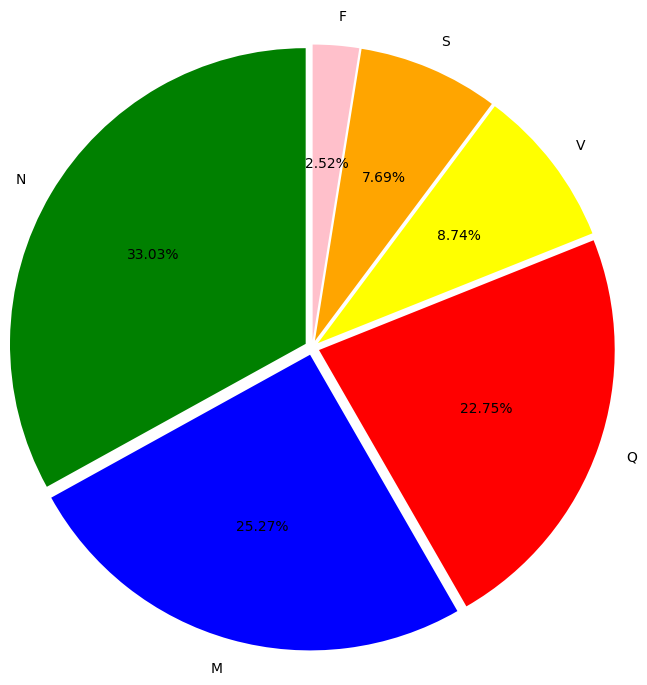

In [6]:
colors = ['green','blue','red','yellow','orange','pink']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05,0.05,0.05,0.05,0.05],autopct='%0.2f%%',labels=['N','M','Q','V','S','F'], colors= colors,radius=2)
plt.show()

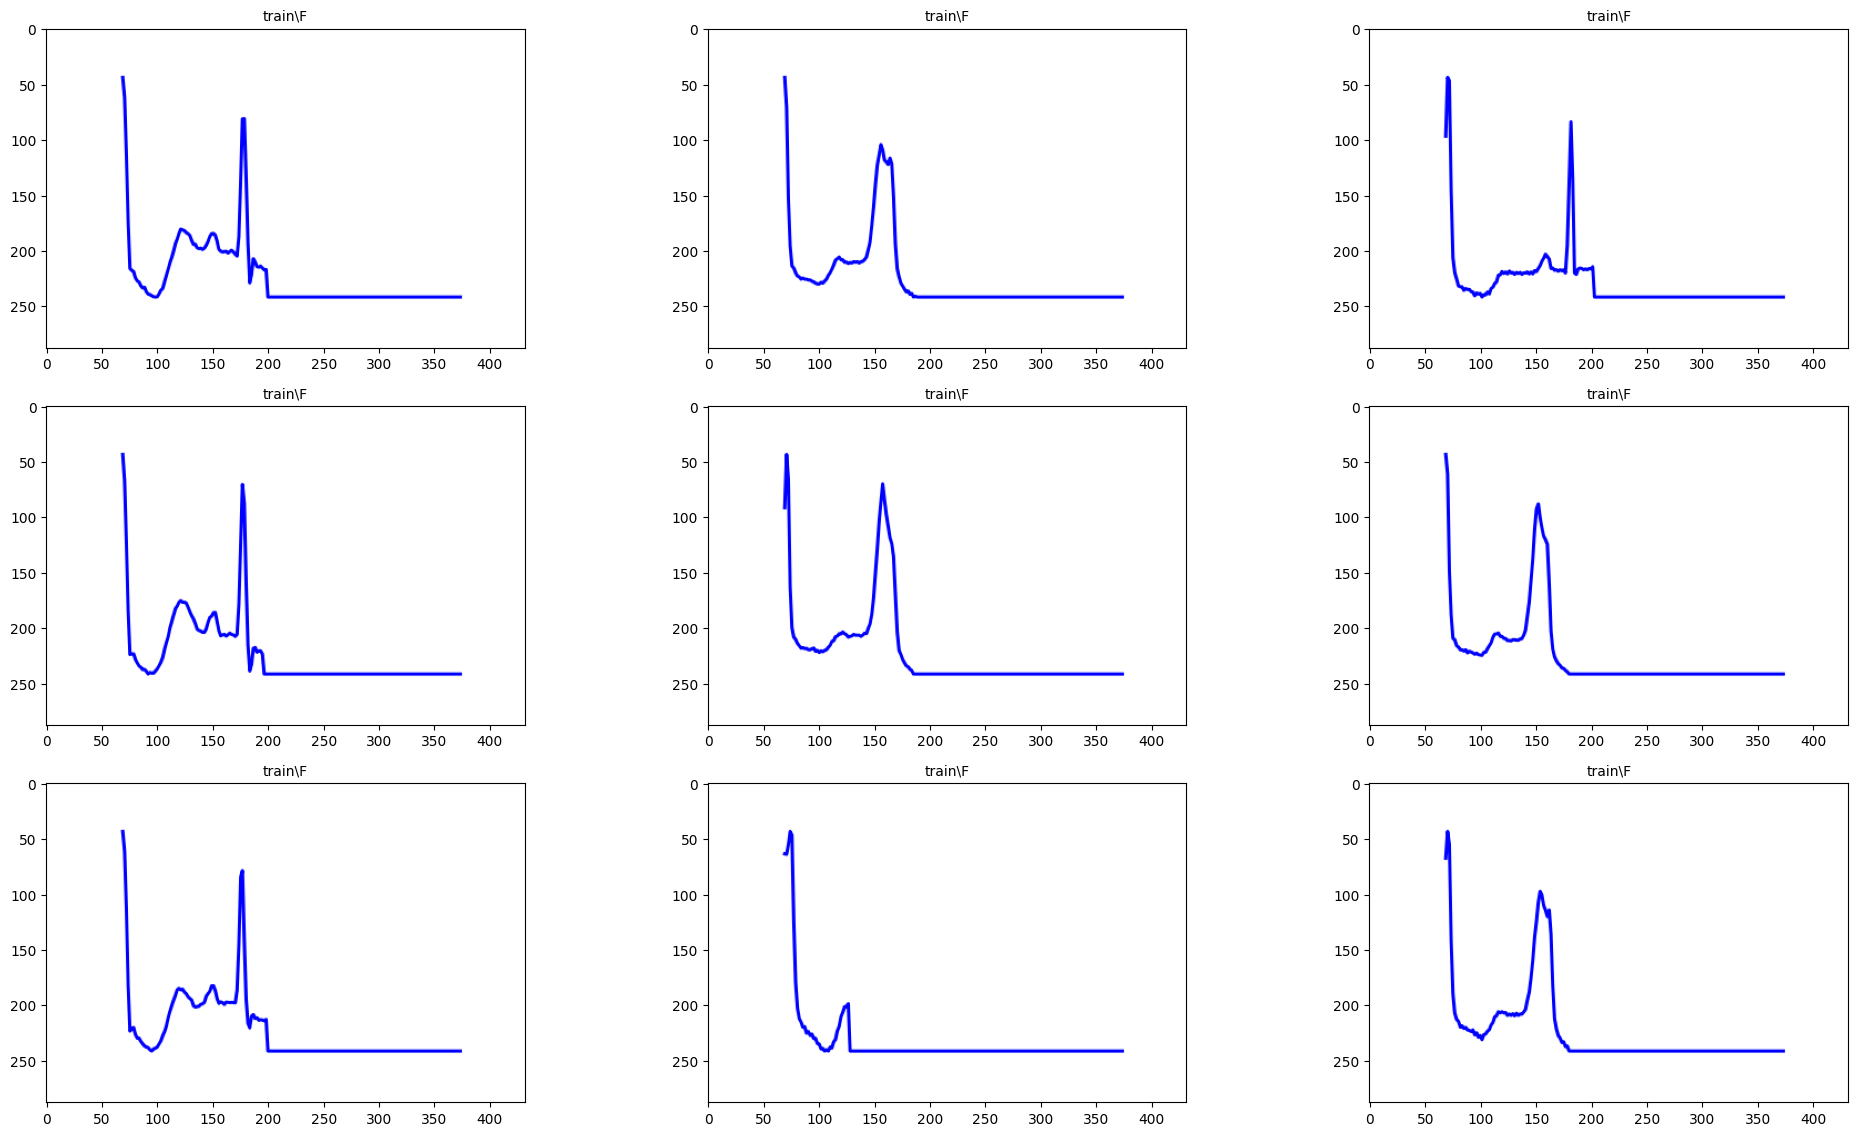

In [7]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(20)
    plt.title('{0}'.format(data.label[index]),fontdict={'size':10})
    plt.imshow(data.image[index])
    plt.tight_layout()

In [8]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  6


In [9]:
x_data = []
y_data = []

for category in glob(test_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data=pd.DataFrame({'image': x_data,'label': y_data})

  0%|          | 0/161 [00:00<?, ?it/s]

100%|██████████| 1447/1447 [00:02<00:00, 583.01it/s]


In [10]:
data.shape

(6137, 2)

In [11]:
from collections import Counter
Counter(y_data)

Counter({'test\\M': 2101,
         'test\\Q': 1608,
         'test\\V': 1447,
         'test\\S': 556,
         'test\\N': 264,
         'test\\F': 161})

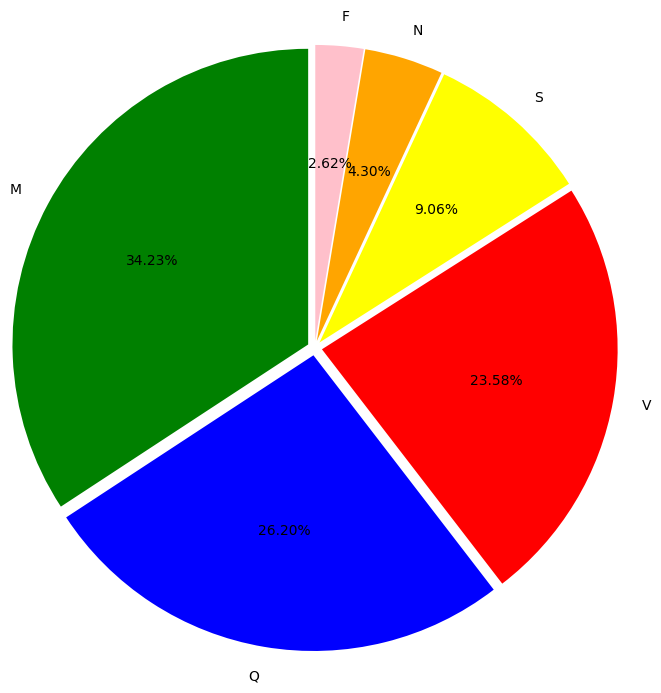

In [12]:
colors = ['green','blue','red','yellow','orange','pink']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05,0.05,0.05,0.05,0.05],autopct='%0.2f%%',labels=['M','Q','V','S','N','F'], colors= colors,radius=2)
plt.show()

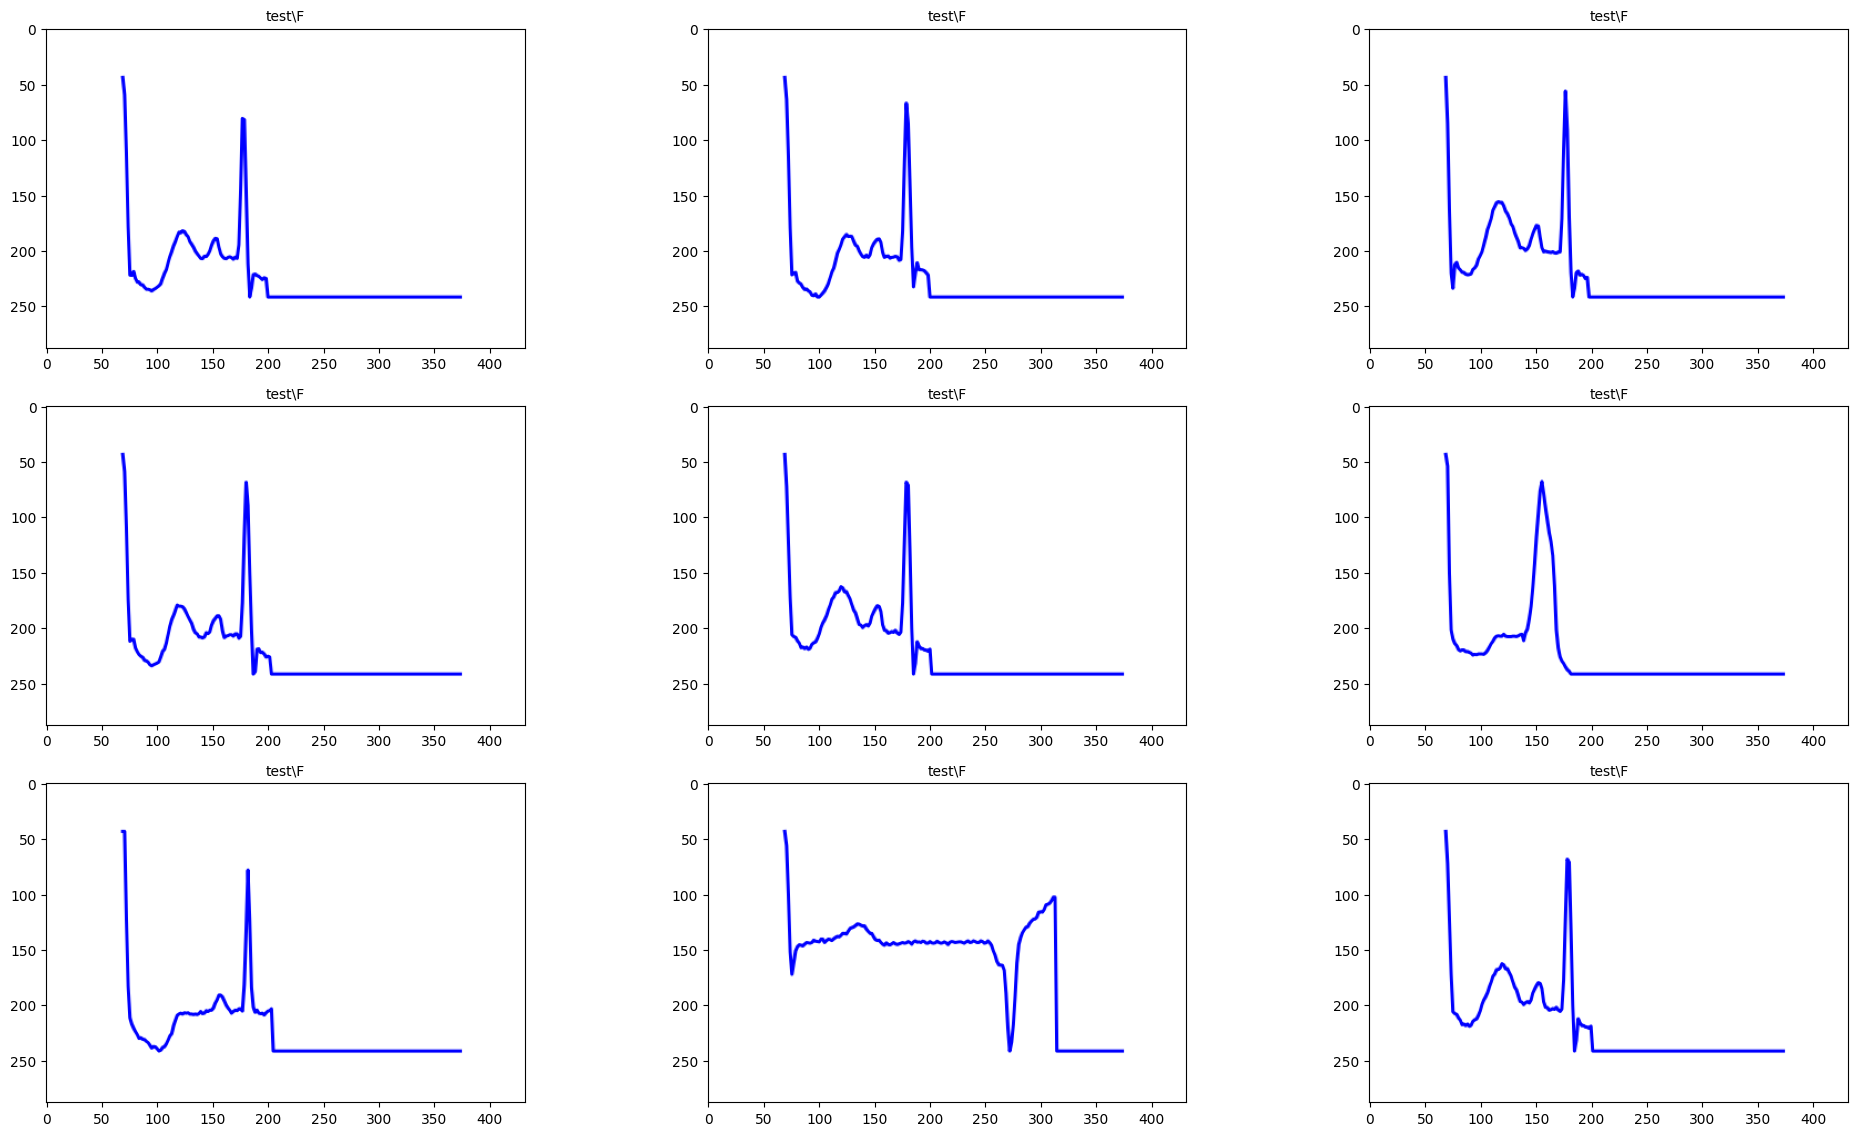

In [13]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(20)
    plt.title('{0}'.format(data.label[index]),fontdict={'size':10})
    plt.imshow(data.image[index])
    plt.tight_layout()

In [14]:
train_generator = ImageDataGenerator(
    rescale = 1.0/255.,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=(0.5, 1.5),
)
test_generator = ImageDataGenerator(rescale=1./255.)

In [15]:
train_datagen = train_generator.flow_from_directory(
    train_path,
    batch_size=250,
    target_size=(224, 224)
)
test_datagen = test_generator.flow_from_directory(
    test_path,
    batch_size=250,
    target_size=(224, 224)
)

Found 25446 images belonging to 6 classes.
Found 6137 images belonging to 6 classes.


ResNet

In [18]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

model_res = Model(inputs=base_model.input, outputs=predictions)

model_res.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_res = model_res.fit(train_datagen, epochs=15, validation_data=test_datagen)

Epoch 1/15
102/102 [==============================] - 1309s 13s/step - loss: 1.1026 - accuracy: 0.6122 - val_loss: 1.2910 - val_accuracy: 0.7280
Epoch 2/15
102/102 [==============================] - 1320s 13s/step - loss: 0.7080 - accuracy: 0.7349 - val_loss: 1.7836 - val_accuracy: 0.4496
Epoch 3/15
102/102 [==============================] - 1316s 13s/step - loss: 0.5734 - accuracy: 0.7863 - val_loss: 1.7226 - val_accuracy: 0.6135
Epoch 4/15
102/102 [==============================] - 1394s 14s/step - loss: 0.4923 - accuracy: 0.8168 - val_loss: 0.4968 - val_accuracy: 0.7913
Epoch 5/15
102/102 [==============================] - 1397s 14s/step - loss: 0.4424 - accuracy: 0.8340 - val_loss: 0.4645 - val_accuracy: 0.8463
Epoch 6/15
102/102 [==============================] - 1406s 14s/step - loss: 0.4203 - accuracy: 0.8422 - val_loss: 1.7492 - val_accuracy: 0.5288
Epoch 7/15
102/102 [==============================] - 1408s 14s/step - loss: 0.4002 - accuracy: 0.8498 - val_loss: 1.0116 - val_ac

In [ ]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.plot(hist_res.history['accuracy'])
plt.plot(hist_res.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(hist_res.history['loss'])
plt.plot(hist_res.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Inception V3

In [23]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

model_inc = Model(inputs=base_model.input, outputs=predictions)

model_inc.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_inc = model_inc.fit(train_datagen, epochs=15, validation_data=test_datagen)

Epoch 1/15
102/102 [==============================] - 767s 7s/step - loss: 0.5426 - accuracy: 0.8178 - val_loss: 0.3966 - val_accuracy: 0.8418
Epoch 2/15
102/102 [==============================] - 745s 7s/step - loss: 0.1852 - accuracy: 0.9365 - val_loss: 0.2076 - val_accuracy: 0.9270
Epoch 3/15
102/102 [==============================] - 746s 7s/step - loss: 0.1432 - accuracy: 0.9492 - val_loss: 0.1655 - val_accuracy: 0.9462
Epoch 4/15
102/102 [==============================] - 743s 7s/step - loss: 0.1170 - accuracy: 0.9586 - val_loss: 0.2137 - val_accuracy: 0.9311
Epoch 5/15
102/102 [==============================] - 746s 7s/step - loss: 0.1064 - accuracy: 0.9629 - val_loss: 0.1536 - val_accuracy: 0.9490
Epoch 6/15
102/102 [==============================] - 745s 7s/step - loss: 0.0957 - accuracy: 0.9665 - val_loss: 0.1121 - val_accuracy: 0.9593
Epoch 7/15
102/102 [==============================] - 744s 7s/step - loss: 0.0924 - accuracy: 0.9677 - val_loss: 0.1169 - val_accuracy: 0.9584

VGG 16

In [16]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=predictions)

model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_vgg = model_vgg.fit(train_datagen, epochs=10, validation_data=test_datagen)

Epoch 1/10
102/102 [==============================] - 2921s 29s/step - loss: 0.3335 - accuracy: 0.8882 - val_loss: 0.8361 - val_accuracy: 0.9001
Epoch 2/10
102/102 [==============================] - 2464s 24s/step - loss: 0.0344 - accuracy: 0.9901 - val_loss: 0.5103 - val_accuracy: 0.7922
Epoch 3/10
102/102 [==============================] - 2432s 24s/step - loss: 0.0156 - accuracy: 0.9957 - val_loss: 0.1408 - val_accuracy: 0.9671
Epoch 4/10
102/102 [==============================] - 2430s 24s/step - loss: 0.0117 - accuracy: 0.9969 - val_loss: 0.0095 - val_accuracy: 0.9998
Epoch 5/10
102/102 [==============================] - 2605s 26s/step - loss: 0.0102 - accuracy: 0.9974 - val_loss: 0.0050 - val_accuracy: 0.9984
Epoch 6/10
102/102 [==============================] - 2505s 25s/step - loss: 0.0064 - accuracy: 0.9982 - val_loss: 0.0042 - val_accuracy: 0.9985
Epoch 7/10
102/102 [==============================] - 2526s 25s/step - loss: 0.0066 - accuracy: 0.9983 - val_loss: 0.0216 - val_ac

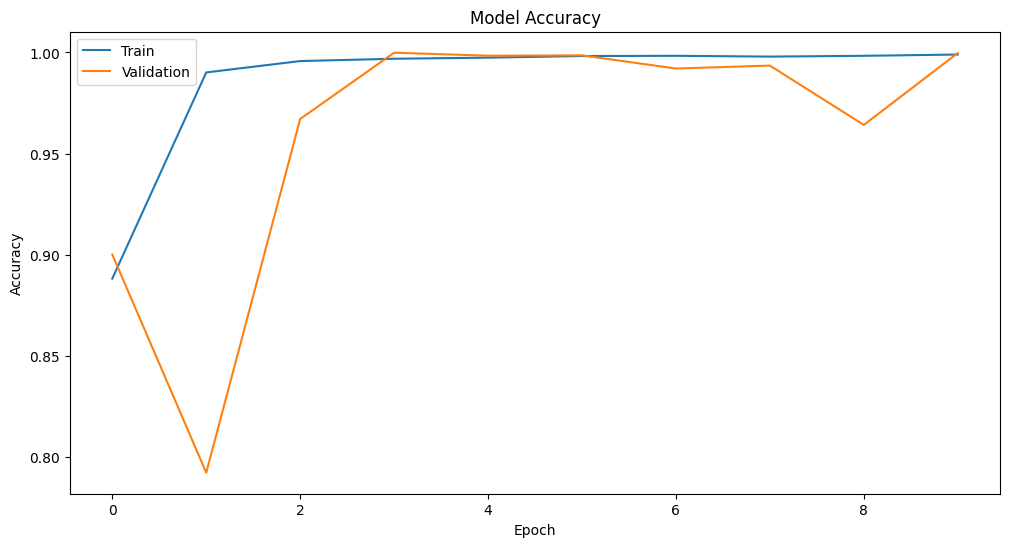

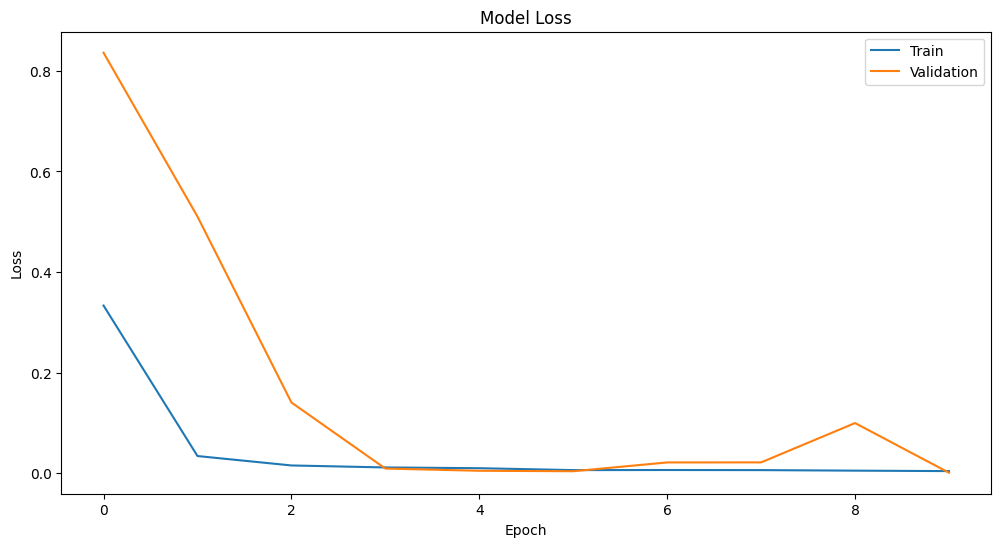

In [17]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.plot(hist_vgg.history['accuracy'], label='Train')
plt.plot(hist_vgg.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Summarize history for loss
plt.figure(figsize=(12, 6))
plt.plot(hist_vgg.history['loss'], label='Train')
plt.plot(hist_vgg.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


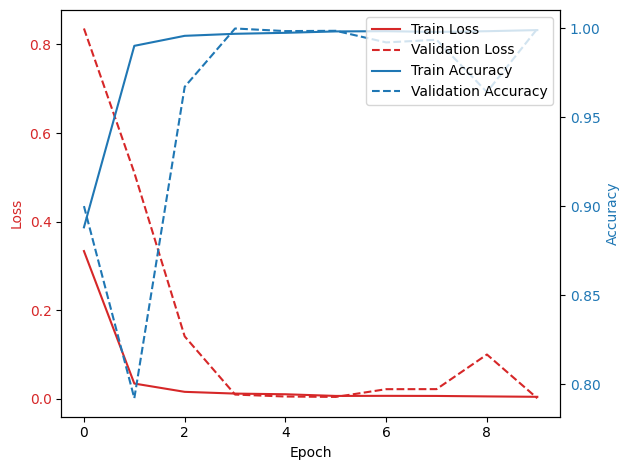

In [19]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(hist_vgg.history['loss'], color=color, label='Train Loss')
ax1.plot(hist_vgg.history['val_loss'], color=color, linestyle='dashed', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(hist_vgg.history['accuracy'], color=color, label='Train Accuracy')
ax2.plot(hist_vgg.history['val_accuracy'], color=color, linestyle='dashed', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()


Proposed Model

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import DepthwiseConv2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define paths
train_dir = "D:/VIT Chennai/SEM 7/Capstone/ecg parts/ECG_Image_data/train"
test_dir = "D:/VIT Chennai/SEM 7/Capstone/ecg parts/ECG_Image_data/test"

# Constants
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 250
NUM_CLASSES = 6 

# Enhanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation')

# Custom Model Architecture
model = Sequential([
    InputLayer(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    DepthwiseConv2D((3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    DepthwiseConv2D((3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    DepthwiseConv2D((3, 3), activation='relu', padding='same'),
    GlobalAveragePooling2D(),
    Dropout(0.4),
    
    # Classifier
    Dense(6, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Callbacks for Early Stopping and Saving the Best Model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)
]

# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=15,  
    callbacks=callbacks,
    verbose=2)

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

evaluation = model.evaluate(test_generator)
print(f'Test Loss: {evaluation[0]}')
print(f'Test Accuracy: {evaluation[1]}')


Found 20359 images belonging to 6 classes.
Found 5087 images belonging to 6 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 depthwise_conv2d (Depthwis  (None, 224, 224, 32)      320       
 eConv2D)                                                        
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 1

C:\Users\Rajat\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 - 1444s - loss: 1.4495 - accuracy: 0.4014 - val_loss: 1.7711 - val_accuracy: 0.2528 - 1444s/epoch - 18s/step
Epoch 3/15
81/81 - 1251s - loss: 1.2038 - accuracy: 0.5054 - val_loss: 1.7690 - val_accuracy: 0.2536 - 1251s/epoch - 15s/step
Epoch 4/15
81/81 - 1430s - loss: 0.9962 - accuracy: 0.5796 - val_loss: 1.7826 - val_accuracy: 0.0250 - 1430s/epoch - 18s/step
Epoch 5/15
81/81 - 1323s - loss: 0.8938 - accuracy: 0.6281 - val_loss: 1.7542 - val_accuracy: 0.0252 - 1323s/epoch - 16s/step
Epoch 6/15
81/81 - 1590s - loss: 0.8493 - accuracy: 0.6604 - val_loss: 1.6050 - val_accuracy: 0.2968 - 1590s/epoch - 20s/step
Epoch 7/15
81/81 - 1207s - loss: 0.8214 - accuracy: 0.6808 - val_loss: 1.2664 - val_accuracy: 0.6106 - 1207s/epoch - 15s/step
Epoch 8/15
81/81 - 1187s - loss: 0.7961 - accuracy: 0.6982 - val_loss: 1.0754 - val_accuracy: 0.8878 - 1187s/epoch - 15s/step
Epoch 9/15
81/81 - 1160s - loss: 0.7654 - accuracy: 0.7177 - val_loss: 0.7874 - val_accuracy: 0.9230 - 1160s/epoch - 14s/step
Epo

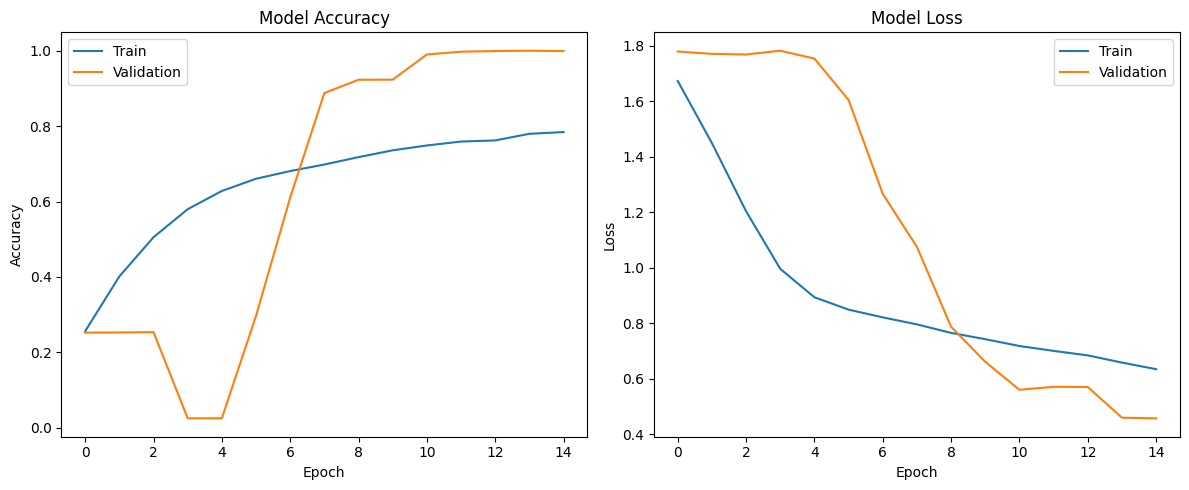

In [2]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


25/25 [==============================] - 99s 4s/step


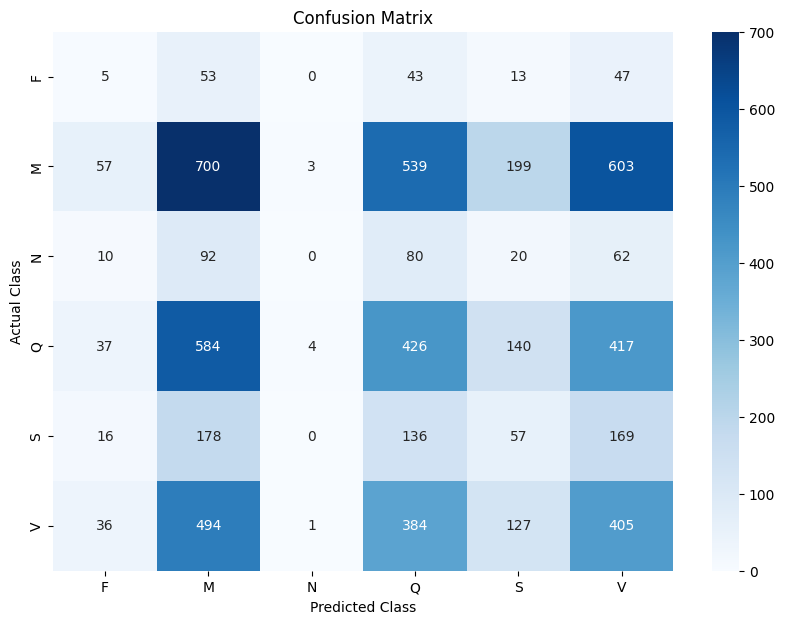

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Assuming that your model is saved as 'best_model.h5' and you want to load it for prediction
model = load_model('best_model.h5')

# Ensure the test_generator is not shuffling data to maintain alignment between predictions and labels
test_generator.reset()

# Generate predictions for all samples
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions from one-hot encoded to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Retrieve the true labels from the test_generator
true_classes = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()
